# Single Frame Workflow
This notebook breaks down the process that each frame goes through, from a video frame to a list of cards.

In [196]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from collections import defaultdict, Counter
import helpers
import constants as const
from ShapeLabeler import ShapeLabeler
from ColorLabeler import ColorLabeler

In [209]:
def plot_image(image: np.ndarray, title: str, convert_color: bool = True):
    """
    Display image in notebook

    :param image: OpenCV image as np.ndarray
    :param title: Title of plot
    :param convert_color: If True, will convert from BGR to RGB
    """
    if convert_color:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(9, 9))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

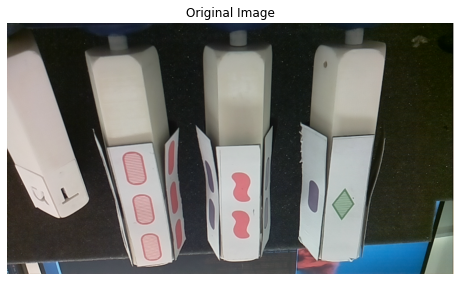

In [198]:
# Load image
image_path = "example_images/old_cards.png"
image = cv2.imread(image_path)
plot_image(image, "Original Image")

# Load saved shapes, this shapes are used for comparing potential shapes to in the final classification stage
saved_shapes = helpers.load_saved_shapes()

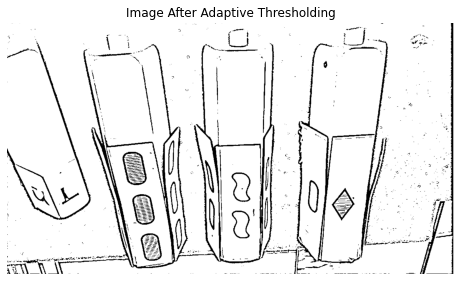

In [199]:
# Convert image to gray for adaptive thresholding
# this is used to extract contours from the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
params = const.ADAPTIVE_THRESHOLD_PARAMS
binary = cv2.adaptiveThreshold(gray, params[0], cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, params[1], params[2])
plot_image(binary, "Image After Adaptive Thresholding")

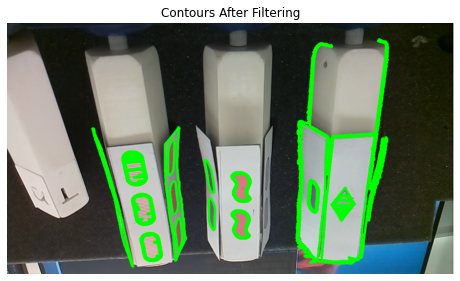

In [200]:
# Contours are extracted from the image
# and areas are calculated and saved since they will be used multiple times later
all_contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
all_contour_areas = [cv2.contourArea(cnt) for cnt in all_contours]

# Potentially relevant shapes are filtered based on area
bottom_thresh = image.shape[0] * image.shape[1] * const.POTENTIAL_SHAPE_SIZE_BOTTOM_THRESHOLD
top_thresh = image.shape[0] * image.shape[1] * const.POTENTIAL_SHAPE_SIZE_TOP_THRESHOLD
potential_shapes = [(cnt, all_contour_areas[idx]) for idx, cnt in enumerate(all_contours)
                            if bottom_thresh <= all_contour_areas[idx] <= top_thresh]

# Sort potential shapes by size in descending order
# this makes sure that if we try to classify two contours that on is included in the other
# we will check the bigger one first
potential_shapes.sort(key=lambda c: c[1], reverse=True)
contour_areas = [c[1] for c in potential_shapes]
potential_shapes = [c[0] for c in potential_shapes]

# We are now left with these contours
image_copy = image.copy()
cont_image = cv2.drawContours(image_copy, potential_shapes, -1, (0, 255, 0), 5)
plot_image(cont_image, "Contours After Filtering")

In [201]:
# More fields that will be used multiple times and need to be saved to avoid redundant calculations
poly_approxes = [cv2.approxPolyDP(c, const.POLY_APPROX_FACTOR * cv2.arcLength(c, True), True)
                 for c in potential_shapes]
contour_centers = [helpers.get_contour_center(c) for c in potential_shapes]

In [202]:
def check_approx_contour_intersect(cnt_idx: int, contour_centers: list, marked_shapes: dict) -> bool:
    """
    Check if the given contour center is within the threshold distance of any other contour center
    A compute cheap approximation for checking if a given contour intersects with the existing classified shapes

    :param cnt_idx: Index of contour center to check
    :param contour_centers: List of contour centers
    :param marked_shapes: Dict of all shapes classified so far
    :return: True if an intersecting contour center is found, False otherwise
    """
    for idx2 in marked_shapes.keys():
        center1 = contour_centers[cnt_idx]
        center2 = contour_centers[idx2]
        dist = helpers.point_distance(center1, center2)
        if dist <= const.CONTOUR_CENTER_DISTANCE_INTERSECT_THRESHOLD:
            return True
    return False

# Init marked shapes, all shapes classified so far
# key: contour index, value: string of shape label
marked_shapes = {}

for idx, cnt in enumerate(potential_shapes):
    if check_approx_contour_intersect(idx, contour_centers, marked_shapes) or \
            helpers.get_flat_angle_pct(poly_approxes[idx]) > const.MAX_FLAT_ANGLE_PCT_THRESHOLD:
        continue
    shape_labeler = ShapeLabeler(cnt, poly_approxes[idx], contour_centers[idx],
                                 contour_areas[idx], saved_shapes)
    shape = shape_labeler.detect_shape()
    if shape is None:
        continue
    marked_shapes[idx] = shape

## Shape Detection
In the cell above all the contours were classified by the `ShapeLabeler` class, let's take a deeper look at the process each shape went through.
The possible labels: `Diamond`, `Wave`, `Oval` and not relevant, which are simply not saved to the marked shapes dict.

First we'll look at the `Diamond` shape, each contour goes through a series of checks and if it passes all those checks it is labaled a Diamond.
All tests check that a geometric parameter is under a predefined threshold saved in `constants`, the tests:
1. The angle between the diagonals is close to 90 degress
2. The area of the shape calculated by OpenCV is close to half of the product of the diagonals (geometric diamond area calculation).
3. The center of the shape calculated by OpenCV is close to the intersection point of the diagonals
4. The width and height ratio of the shape is in a predefined range, this helps understand if we are looking at a shape that is directly in front of us or that is on one of the tiles that is angled and isn't of interest to us at the moment.

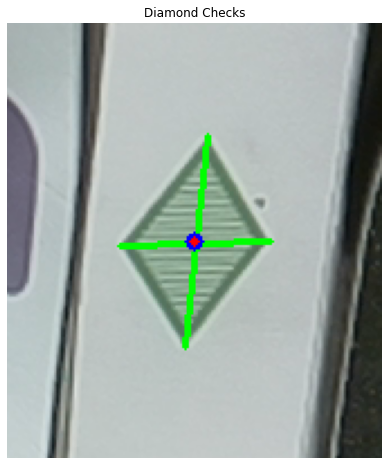

In [203]:
def crop_contour(cnt: np.array, image: np.ndarray, buffer: int) -> np.ndarray:
    """
    Crops a contour out of a given image

    :param cnt: The contour to crop
    :param image: The image to crop
    :param buffer: The number of extra pixels to crop around the contour
    """
    extreme_points = helpers.get_contour_extreme_points(cnt)
    return image[extreme_points[1][1] - buffer:extreme_points[3][1] + buffer, extreme_points[0][0] - buffer:extreme_points[2][0] + buffer]


first_diamond_idx = [idx for idx, shape in marked_shapes.items() if shape == 'D'][0]
first_diamond_contour = potential_shapes[first_diamond_idx]
extreme_points = helpers.get_contour_extreme_points(first_diamond_contour)
horz_diag = [extreme_points[0], extreme_points[2]]
vert_diag = [extreme_points[1], extreme_points[3]]
int_point = helpers.get_line_intersection(horz_diag, vert_diag)
opencv_center = contour_centers[first_diamond_idx]

show_diamond_checks = image.copy()
show_diamond_checks = cv2.line(show_diamond_checks, horz_diag[0], horz_diag[1], (0, 255, 0), 2)
show_diamond_checks = cv2.line(show_diamond_checks, vert_diag[0], vert_diag[1], (0, 255, 0), 2)
show_diamond_checks = cv2.circle(show_diamond_checks, int_point, radius=0, color=(255, 0, 0), thickness=7)
show_diamond_checks = cv2.circle(show_diamond_checks, opencv_center, radius=0, color=(0, 0, 255), thickness=4)
show_diamond_checks = crop_contour(first_diamond_contour, show_diamond_checks, 50)
plot_image(show_diamond_checks, "Diamond Checks")

In the image above you can see the diagonals, their intersection (in blue) and the center of the contour according to OpenCV (in red).
You can see that the red and blue points are almost identical, showing that passing this test means that the contour is more likely to be a diamond.

Now we can take a look at the `Wave` and `Oval` classification methods, both use a similar logic that proved to be very reliable.
Similar to the `Diamond`, there are a list of tests that a contour must pass in order to be a `Wave` \ `Oval`, the tests:
1. In Out stat (will be explained shortly) is in a predefined range.
2. The width and height ratio of the shape is in a predefined range, this helps understand if we are looking at a shape that is directly in front of us or that is on one of the tiles that is angled and isn't of interest to us at the moment.
3. Shape matching compared to the saved shapes mentioned earlier gets a good score.

More about In Out stat - while trying many methods to differentiate between `Wave` and `Oval` I thought about this method that proved to be veru reliable.
This method takes the [polygon approximation of a contour](https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html#:~:text=4.%20Contour%20Approximation),
stretches lines between different points in the approximation according to a `jump` parameter and tests if middle point of the line is inside or outside the contour.

(-0.5, 169.5, 195.5, -0.5)

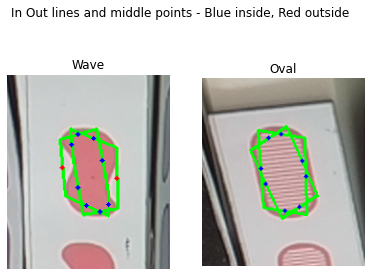

In [204]:
def draw_in_out_lines_and_points(cnt: np.array, poly_approx: np.array, jump: int, image: np.ndarray) -> np.ndarray:
    """
    Draws the lines and points used for the in out stat

    :param cnt: The contour we are testing
    :param poly_approx: The poly approx of the same contour
    :param jump: The number of points to jump in each line connection
    :param image: The image to draw on
    """

    image = image.copy()
    points = []
    l = len(poly_approx)
    # Draw lines and save points
    for idx, p1 in enumerate(poly_approx):
        p1 = p1[0]
        p2 = poly_approx[(idx + jump) % l][0]
        image = cv2.line(image, p1, p2, (0, 255, 0), 2)
        points.append(helpers.get_midpoint(p1, p2))

    # Draw points after lines
    for point in points:
        res = cv2.pointPolygonTest(cnt, point, False)
        if res == 1:
            color = (255, 0, 0)
        else:
            color = (0, 0, 255)
        image = cv2.circle(image, np.array(point, dtype=int), radius=0, color=color, thickness=4)

    # Return the cropped image
    return crop_contour(cnt, image, 50)


first_wave_idx = [idx for idx, shape in marked_shapes.items() if shape == 'W'][0]
first_wave_contour = potential_shapes[first_wave_idx]
first_wave_poly_approx = poly_approxes[first_wave_idx]

first_oval_idx = [idx for idx, shape in marked_shapes.items() if shape == 'O'][0]
first_oval_contour = potential_shapes[first_oval_idx]
first_oval_poly_approx = poly_approxes[first_oval_idx]

show_wave_in_out = draw_in_out_lines_and_points(first_wave_contour, first_wave_poly_approx, 2, image)
show_oval_in_out = draw_in_out_lines_and_points(first_oval_contour, first_oval_poly_approx, 2, image)

show_wave_in_out = cv2.cvtColor(show_wave_in_out, cv2.COLOR_BGR2RGB)
show_oval_in_out = cv2.cvtColor(show_oval_in_out, cv2.COLOR_BGR2RGB)

f, axarr = plt.subplots(1,2)
f.suptitle("In Out lines and middle points - Blue inside, Red outside")
axarr[0].imshow(show_wave_in_out)
axarr[0].title.set_text("Wave")
axarr[0].axis("off")
axarr[1].imshow(show_oval_in_out)
axarr[1].title.set_text("Oval")
axarr[1].axis("off")

As you can see in the figure above, the `Wave` has some middle points fall outside the contour, while the `Oval` doesn't.
This is a geometrical property of these shapes which is always true, thus is proves as a reliable differentiating property.

Shape matching, `Wave` and `Oval` candidates also undergo shape matching using [OpenCV `matchShapes` method](https://docs.opencv.org/3.4/d5/d45/tutorial_py_contours_more_functions.html#:~:text=2%2D3X%20speedup.-,3.%20Match%20Shapes,-OpenCV%20comes%20with)
which tests the shape against the saved shapes that are loaded at the beginning of the process.
Why not use only this method? Because it is very inaccurate, it only proved helpful as a
final test once the code already suspects a shape could be a `Wave` or an `Oval`.

The final product of the shape detection stage is that only the relevant contours are labeled as you can see below.

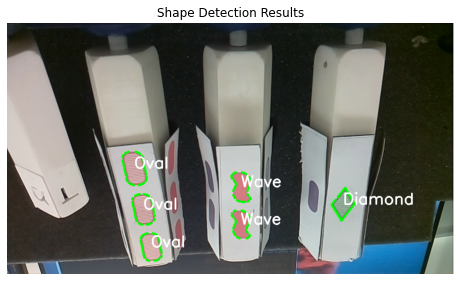

In [205]:
show_contours = image.copy()
shape_map = {'W': "Wave", 'D': "Diamond", 'O': "Oval"}

for cnt_idx, shape in marked_shapes.items():
    c_center = contour_centers[cnt_idx]
    show_contours = cv2.drawContours(show_contours, potential_shapes[cnt_idx], -1, (0, 255, 0), 5)
    show_contours = cv2.putText(show_contours, shape_map.get(shape), (c_center[0], c_center[1]), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 4)

plot_image(show_contours, "Shape Detection Results")


## Shape Grouping into Cards

In this stage the shapes are grouped into cards, this is done in a very simple manner because we can use
the fact that im this project, we will only see a single card in the vertical axis.
So the grouping is done based on a predefined threshold of image width that the centers of two cards can be
in order to be considered in the same card.

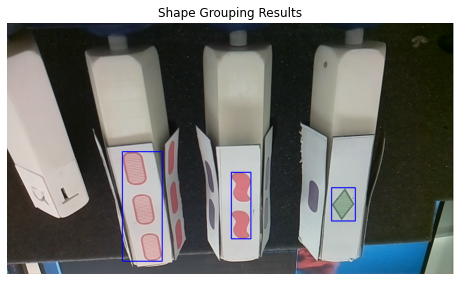

In [206]:
show_shape_grouping = image.copy()
image_width = image.shape[1]
cards = defaultdict(list)
for cnt_idx, shape in marked_shapes.items():
    card_center = helpers.match_card(contour_centers[cnt_idx], cards, image_width)
    card_center = contour_centers[cnt_idx] if card_center is None else card_center
    cards[tuple(card_center)].append((cnt_idx, shape))

for card, shapes in cards.items():
    card_cnt = np.concatenate([potential_shapes[s[0]] for s in shapes])
    x, y, w, h = cv2.boundingRect(card_cnt)
    show_shape_grouping = cv2.rectangle(show_shape_grouping, (x, y), (x + w, y + h), (255, 0, 0), 2)

plot_image(show_shape_grouping, "Shape Grouping Results")


## Color and Fill

Now that we have each of the shapes and the shapes grouped into cards
, we need to understand the color and fill of each card.
The method that proved most reliable was using KMeans with K=2 on the color values of the pixels
in the bounding box of the biggest shape in each card.\
Why use the pixels in the bounding box and not the pixels in the contour?
Getting only the pixels inside the contour is CPU intensive, and since the background of the
shape and the card are the same color, the bounding box proved to be accurate enough.\
Why set K=2? Because for every shape we will have two colors, white paired with red, green or blue.

I got to this idea from [this post](https://towardsdatascience.com/finding-most-common-colors-in-python-47ea0767a06a) which was very helpful :)

Before running KMeans the image is converted to the [LAB color space](https://www.xrite.com/blog/lab-color-space)
, in this space euclidean distance between colors is more true to real life.

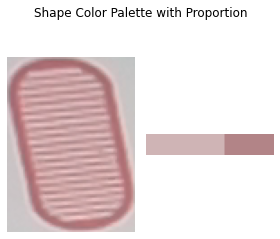

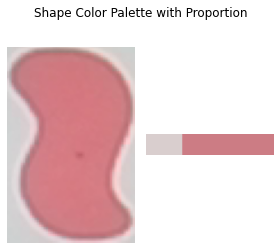

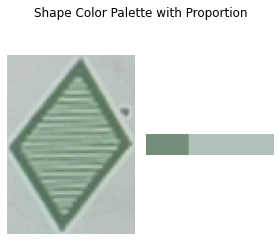

In [207]:
def plot_side_by_side(left_image: np.ndarray, right_image: np.ndarray):
    """
    Plots two images side by side

    :param left_image: left image
    :param right_image: right image
    """
    f, ax = plt.subplots(1, 2, figsize=(4, 4))
    ax[0].imshow(left_image)
    ax[1].imshow(right_image)
    ax[0].axis('off')
    ax[1].axis('off')
    f.tight_layout()
    f.suptitle("Shape Color Palette with Proportion")
    plt.show()


def get_palette_image(k_cluster: MiniBatchKMeans) -> np.ndarray:
    """
    Creates a palette image for a given clustering result
    Taken from: https://towardsdatascience.com/finding-most-common-colors-in-python-47ea0767a06a

    :param k_cluster: The algorithm object after fitting
    :return: The palette image
    """
    width = 300
    palette = np.zeros((50, width, 3), np.uint8)

    n_pixels = len(k_cluster.labels_)
    counter = Counter(k_cluster.labels_) # count how many pixels per cluster
    perc = {}
    for i in counter:
        perc[i] = np.round(counter[i]/n_pixels, 2)
    perc = dict(sorted(perc.items()))

    step = 0

    for idx, center in enumerate(k_cluster.cluster_centers_):
        rgb_center = list(cv2.cvtColor(np.array([[center.astype("uint8")]]), cv2.COLOR_LAB2RGB)[0][0])
        palette[:, step:int(step + perc[idx]*width+1), :] = rgb_center
        step += int(perc[idx]*width+1)

    return palette

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
clt = MiniBatchKMeans(n_clusters=2, tol=1e-3)

for shapes in cards.values():
    first_shape_cnt = potential_shapes[shapes[0][0]]
    x, y, w, h = cv2.boundingRect(first_shape_cnt)
    rgb_rect_pixels = rgb_image[y:y + h, x:x + w]
    lab_rect_pixels = lab_image[y:y + h, x:x + w]
    palette = get_palette_image(clt.fit(lab_rect_pixels.reshape(-1, 3)))
    plot_side_by_side(rgb_rect_pixels, palette)

We can see that each shape has a cluster that is close to white and a cluster that isn't.
The proportion between the two clusters is shown by the cluster size and this proportion determines the fill.
The fill can be `Full`, `Empty` or `Stripped`, which will be classified according to the range the proportion falls into.

In order to determine the color between `Red`, `Blue` and `Green` the hue element of [HSV](https://www.lifewire.com/what-is-hsv-in-design-1078068)
is used. This proved to be most reliable and robust when it comes to different lighting conditions.
The process first detects the non-white color and then sees which one of the three predefined
hue values (one for each color) it is closest to.

## Final Result

Here you can see the final result marked on the image.
Each card in represented in the following format:
1. Shape: O - Oval / W - Wave / D - Diamond
2. Color: R - Red / G - Green / P - Purple
3. Amount: 1 / 2 / 3
4. Fill: C - Clear / S - Striped / F - Full

So for example a Diamond, Red, 3, Full card would be encoded as: DR3F

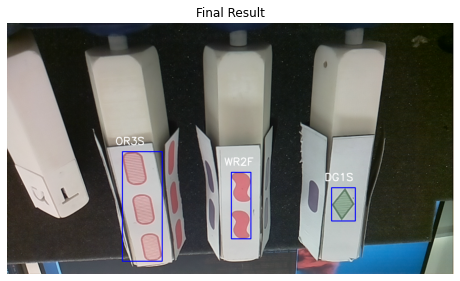

In [208]:
color_labeler = ColorLabeler(image)
final_result = show_shape_grouping

for card_center, shapes in cards.items():
    cnt_idx, shape = shapes[0]
    cnt = potential_shapes[cnt_idx]
    color, fill = color_labeler.get_cnt_color_and_fill(cnt, shape)
    count = len(shapes)
    card_value = f"{shape}{color}{count}{fill}"
    card_cnt = np.concatenate([potential_shapes[s[0]] for s in shapes])
    x, y, w, h = cv2.boundingRect(card_cnt)
    final_result = cv2.putText(show_shape_grouping, card_value, (x - 20, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

plot_image(final_result, "Final Result")